# Исходные данные

Даны исторические данные о заказах такси в аэропортах

Целевой признак - количество заказов столбец 'num_orders' 

# Задача

Построить модель для прогноза количества заказов такси на следующий час.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Обзор данных

In [1]:
# установка библиотек

%pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [3]:
# при открытии файла сразу приведем колонку с датой в формат временного ряда - формат datetime, затем в индексы

try:
    data = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=[0])

In [4]:
# обзор данных

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# обзор данных

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# проверим даты на хронологический порядок

data.index.is_monotonic

True

<div class="alert alert-block alert-warning">

**Итог обзора данных**

 - предоставлены данные с февраля по август 2018 (полгода)
 - нет пропусков в данных
 - данные приведены к формату временного ряда
 - проведена проверка на хронологический порядок дат

# Предобработка

In [7]:
# т.к необходим прогноз на час - выполним ресемплирование по часу
# т.к предоставлены данные за каждые 10 минут - применим суммирование к выводному часу

data = data.resample('1H').sum()

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
# оценим сезонность и тренды временного ряда

decomposed = seasonal_decompose(data)

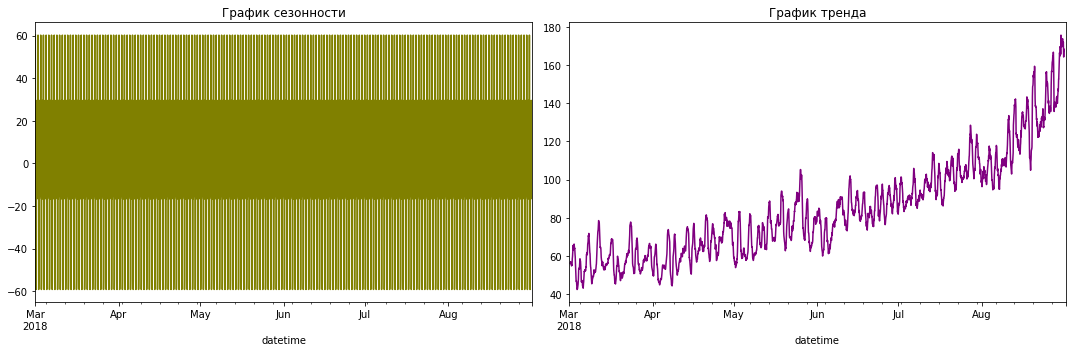

In [10]:
# визуализируем данные

plt.figure(figsize=(15,5))

plt.subplot(121)
decomposed.seasonal.plot(ax=plt.gca(), color='olive')
plt.title('График сезонности')

plt.subplot(122)
decomposed.trend.plot(ax=plt.gca(), color='purple')
plt.title('График тренда')

plt.tight_layout()

## Создание признаков 

Так как в таблице на данный момент только индексы и целевой признак - добавим признаки для обучения

Напишем функцию для добавления признаков

In [11]:
def add_column(df, max_lag, rolling_mean):
    
    # создадим копию датасета
    df_1 = df.copy()
    
    # добавление календарных признаков
    df_1['month'] = df_1.index.month
    df_1['dayofweek'] = df_1.index.dayofweek
    df_1['hour'] = df_1.index.hour
    
    # добавление колонок с лагами - общим количеством max_lag
    for l in range(1, max_lag+1):
        df_1['lag_{}'.format(l)] = df_1['num_orders'].shift(l)
        
    # добавление скользящего среднего без включения текущего значения ряда (без утечки целевого признака)
    df_1['rolling_mean'] = df_1['num_orders'].shift().rolling(rolling_mean).mean()
    
    # вернем датасет с удаленными из-за сдвигов NaN    
    return df_1.dropna()

## Подготовка к обучению 

Напишем функцию для разделения на обучающую, валидационную и тестовую выборку - размер тестовой выборки 10% от датасета

In [12]:
def prepare_learning(df):
    
    # выделим целевой признак и признаки для обучения
    X = df.drop(['num_orders'], axis=1)
    y = df['num_orders']
    
    # разделим данные на выборки - тестовая 10% от датасета, обучающая и валидационная - 7:3 
    X_common, X_test, y_common, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=123)
    X_train, X_valid, y_train, y_valid = train_test_split(X_common, y_common, shuffle=False, test_size=0.3, random_state=123)
    
    # вернем полученные выборки
    return X_train, X_valid, X_test, y_train, y_valid, y_test

## Подбор признаков 

Для получения лучшей метрики есть два пути: 
 - подбор оптимальных признаков датасета (настройка кол-ва лагов и размера скользящего окна)
 - подбор гиперпараметров самой модели 
 
Поэтому напишем также функцию, которая позволит подобрать оптимальные признаки при работе с моделью на основе лучшего показателя RMSE  

In [13]:
def search_params(our_model, df):
    
    model = our_model
    df_1 = df
    
    # задаем список и размерами окна - от 6 до 120 часов
    rolling = [6, 12, 24, 36, 48, 72, 84, 120]
    # лучший RMSE изначально зададим высшим порогом - нам необходимо получить показатель ниже
    best_rmse = 48
    best_lag = 0
    best_window = 0
    
    # используем цикл с цикле для поиска оптимальных параметров
    for lag in range(1,10):
        for window in rolling:
            df_taxi = add_column(df_1, lag, window)
            X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_learning(df_taxi)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)

            rmse = mean_squared_error(y_valid, y_pred)**.5
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_lag = lag
                best_window = window
                
    # вернем лучшие показатели качества, кол-ва лагов и размер окна скользящего среднего           
    return best_rmse, best_lag, best_window   

# Обучение. Поиск лучшей модели

##  LinearRegression

Так как линейная регрессия самая быстрая модель из всех, которые мы будем использовать - для ускорения процесса попробуем подобрать количество лагов и размер окна скользящего среднего именно через нее.

Эти параметры потом будем использовать при поиске по сетке с Деревом решений и Случайным лесом

In [15]:
lr_model = LinearRegression()   

lr_rmse, lr_lag, lr_window = search_params(lr_model, data)

print('Линейная регрессия\n')
print('Лучший показатель RMSE -', lr_rmse)
print('Количество лагов -', lr_lag)
print('Размер окна скользящего среднего -', lr_window)

Линейная регрессия

Лучший показатель RMSE - 36.13015226038554
Количество лагов - 9
Размер окна скользящего среднего - 24


## DecisionTreeRegressor

In [16]:
# подготовим данные для поиска по сетке

data_taxi = add_column(data, 9, 24)
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_learning(data_taxi)

In [17]:
# добавим кросс-валидатор для работы с временными рядами, чтобы не менять их последовательность

tscv = TimeSeriesSplit(n_splits=5)

In [18]:
# зададим параметры сетки дерева

tree_params = {'max_depth': range (1,11,2),
              'min_samples_leaf': range (1,6),
              'min_samples_split': range (2,8,2) 
              }

In [19]:
# применим GridSearchCV и выведем лучшие гиперпараметры

tree = DecisionTreeRegressor()

grid_tree = GridSearchCV(tree, tree_params, cv=tscv, scoring='neg_mean_squared_error')
grid_tree.fit(X_train, y_train)
grid_tree.best_params_

{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6}

In [20]:
# выведем RMSE лучшей модели по сетке

tree_model = DecisionTreeRegressor(**grid_tree.best_params_)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_valid)

grid_tree_rmse = mean_squared_error(y_valid, tree_pred)**.5

print('RMSE поиска по сетке', grid_tree_rmse)

RMSE поиска по сетке 36.25549398855704


In [21]:
# попробуем изменить признаки и вывести лучший RMSE 

tree_model = DecisionTreeRegressor(**grid_tree.best_params_)   

tree_rmse, tree_lag, tree_window = search_params(tree_model, data)

print('Дерево решений\n')
print('Лучший показатель RMSE -', tree_rmse)
print('Количество лагов -', tree_lag)
print('Размер окна скользящего среднего -', tree_window)

Дерево решений

Лучший показатель RMSE - 34.789155833775006
Количество лагов - 6
Размер окна скользящего среднего - 24


##  RandomForestRegressor

In [22]:
# зададим параметры сетки леса

forest_params = {'n_estimators': range (10, 50, 10),
                 'max_depth': range (1,7,2),
                 'min_samples_leaf': range (1,3),
                 'min_samples_split': range (2,4,2) 
                }

In [23]:
# применим GridSearchCV и выведем лучшие параметры

forest = RandomForestRegressor()

grid_forest = GridSearchCV(forest, forest_params, cv=tscv, scoring='neg_mean_squared_error')
grid_forest.fit(X_train, y_train)
grid_forest.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 40}

In [24]:
# выведем RMSE лучшей модели по сетке

forest_model = RandomForestRegressor(**grid_tree.best_params_)  
forest_model.fit(X_train, y_train)
forest_pred = forest_model.predict(X_valid)

grid_forest_rmse = mean_squared_error(y_valid, forest_pred)**.5

print('RMSE поиска по сетке', grid_forest_rmse)

RMSE поиска по сетке 33.74642549713152


In [25]:
# попробуем изменить признаки и вывести лучший RMSE 

forest_model = RandomForestRegressor(**grid_tree.best_params_)   

forest_rmse, forest_lag, forest_window = search_params(forest_model, data)

print('Случайный лес\n')
print('Лучший показатель RMSE -', forest_rmse)
print('Количество лагов -', forest_lag)
print('Размер окна скользящего среднего -', forest_window)

Случайный лес

Лучший показатель RMSE - 33.01461613893788
Количество лагов - 3
Размер окна скользящего среднего - 12


## CatBoostRegressor

In [26]:
# зададим параметры сетки леса

boost_params = {'depth': range(4, 10, 2),
                'iterations': range(10, 50, 10),
                'loss_function' : ['RMSE']
               }

In [27]:
# применим GridSearchCV и выведем лучшие параметры

cat = CatBoostRegressor()

grid_boost = GridSearchCV(cat, boost_params, cv=tscv, scoring='neg_mean_squared_error')
grid_boost.fit(X_train, y_train, verbose=False)
grid_boost.best_params_

{'depth': 4, 'iterations': 40, 'loss_function': 'RMSE'}

In [28]:
# выведем RMSE лучшей модели по сетке

boost_model = CatBoostRegressor(**grid_boost.best_params_)  
boost_model.fit(X_train, y_train, verbose=False)
boost_pred = boost_model.predict(X_valid)

grid_boost_rmse = mean_squared_error(y_valid, boost_pred)**.5

print('RMSE поиска по сетке', grid_boost_rmse)

RMSE поиска по сетке 31.027983749475986


In [29]:
# попробуем изменить признаки и вывести лучший RMSE 

boost_model = CatBoostRegressor(**grid_boost.best_params_)     

boost_rmse, boost_lag, boost_window = search_params(boost_model, data)

print('Градиентный бустинг\n')
print('Лучший показатель RMSE -', boost_rmse)
print('Количество лагов -', boost_lag)
print('Размер окна скользящего среднего -', boost_window)

Learning rate set to 0.5
0:	learn: 28.1658532	total: 1ms	remaining: 39.2ms
1:	learn: 25.3997108	total: 1.97ms	remaining: 37.4ms
2:	learn: 24.1573404	total: 3ms	remaining: 37ms
3:	learn: 23.8276062	total: 3.93ms	remaining: 35.4ms
4:	learn: 23.1577679	total: 4.89ms	remaining: 34.3ms
5:	learn: 22.3687505	total: 5.77ms	remaining: 32.7ms
6:	learn: 22.0502141	total: 6.63ms	remaining: 31.3ms
7:	learn: 21.6687095	total: 7.54ms	remaining: 30.2ms
8:	learn: 21.4712832	total: 8.34ms	remaining: 28.7ms
9:	learn: 21.3771045	total: 9.06ms	remaining: 27.2ms
10:	learn: 21.0441797	total: 9.98ms	remaining: 26.3ms
11:	learn: 20.9126730	total: 11.2ms	remaining: 26.1ms
12:	learn: 20.8446985	total: 12.1ms	remaining: 25.2ms
13:	learn: 20.7731295	total: 13ms	remaining: 24.2ms
14:	learn: 20.6933032	total: 13.9ms	remaining: 23.1ms
15:	learn: 20.5375258	total: 14.7ms	remaining: 22ms
16:	learn: 20.3651814	total: 15.6ms	remaining: 21.1ms
17:	learn: 20.2085485	total: 16.5ms	remaining: 20.1ms
18:	learn: 19.9328782	tot

10:	learn: 21.4293337	total: 9.09ms	remaining: 24ms
11:	learn: 21.2028000	total: 10.2ms	remaining: 23.7ms
12:	learn: 21.0422705	total: 11.1ms	remaining: 23.1ms
13:	learn: 20.8931682	total: 12ms	remaining: 22.3ms
14:	learn: 20.7169425	total: 13ms	remaining: 21.6ms
15:	learn: 20.4180699	total: 14.2ms	remaining: 21.2ms
16:	learn: 20.2252747	total: 14.9ms	remaining: 20.2ms
17:	learn: 20.0983206	total: 15.7ms	remaining: 19.2ms
18:	learn: 19.9923203	total: 17ms	remaining: 18.7ms
19:	learn: 19.9070227	total: 17.7ms	remaining: 17.7ms
20:	learn: 19.7515221	total: 18.5ms	remaining: 16.7ms
21:	learn: 19.5536033	total: 19.7ms	remaining: 16.1ms
22:	learn: 19.2646630	total: 20.6ms	remaining: 15.2ms
23:	learn: 19.1884334	total: 21.5ms	remaining: 14.3ms
24:	learn: 19.0279271	total: 22.4ms	remaining: 13.5ms
25:	learn: 18.9381272	total: 23.2ms	remaining: 12.5ms
26:	learn: 18.8334809	total: 24.1ms	remaining: 11.6ms
27:	learn: 18.7430776	total: 25ms	remaining: 10.7ms
28:	learn: 18.6812005	total: 25.9ms	re

0:	learn: 29.5081609	total: 778us	remaining: 30.4ms
1:	learn: 26.0129687	total: 1.66ms	remaining: 31.6ms
2:	learn: 24.4999236	total: 2.8ms	remaining: 34.6ms
3:	learn: 23.7185769	total: 3.61ms	remaining: 32.5ms
4:	learn: 23.2663229	total: 4.48ms	remaining: 31.4ms
5:	learn: 22.9318916	total: 5.31ms	remaining: 30.1ms
6:	learn: 22.5113449	total: 6.09ms	remaining: 28.7ms
7:	learn: 22.4014573	total: 7ms	remaining: 28ms
8:	learn: 21.9108021	total: 7.86ms	remaining: 27.1ms
9:	learn: 21.6003007	total: 9ms	remaining: 27ms
10:	learn: 21.5506109	total: 9.86ms	remaining: 26ms
11:	learn: 21.2741262	total: 10.7ms	remaining: 25ms
12:	learn: 21.1703217	total: 11.6ms	remaining: 24.1ms
13:	learn: 21.0062111	total: 12.3ms	remaining: 22.9ms
14:	learn: 20.9689794	total: 13.2ms	remaining: 21.9ms
15:	learn: 20.6186411	total: 13.9ms	remaining: 20.8ms
16:	learn: 20.4604000	total: 14.7ms	remaining: 19.9ms
17:	learn: 20.2914917	total: 15.4ms	remaining: 18.8ms
18:	learn: 20.1080799	total: 16.2ms	remaining: 17.9ms


0:	learn: 27.7778793	total: 835us	remaining: 32.6ms
1:	learn: 25.8735035	total: 1.77ms	remaining: 33.6ms
2:	learn: 24.6524248	total: 2.71ms	remaining: 33.4ms
3:	learn: 23.9706922	total: 3.58ms	remaining: 32.2ms
4:	learn: 23.4536140	total: 4.56ms	remaining: 31.9ms
5:	learn: 22.9767841	total: 5.4ms	remaining: 30.6ms
6:	learn: 22.8406041	total: 6.3ms	remaining: 29.7ms
7:	learn: 22.1656848	total: 7.21ms	remaining: 28.9ms
8:	learn: 21.9111086	total: 8.2ms	remaining: 28.2ms
9:	learn: 21.5368085	total: 9.48ms	remaining: 28.4ms
10:	learn: 21.3002987	total: 10.5ms	remaining: 27.7ms
11:	learn: 21.0312358	total: 11.4ms	remaining: 26.6ms
12:	learn: 20.9715197	total: 12.1ms	remaining: 25.1ms
13:	learn: 20.8607288	total: 12.9ms	remaining: 23.9ms
14:	learn: 20.8198558	total: 13.8ms	remaining: 23.1ms
15:	learn: 20.4761690	total: 14.6ms	remaining: 21.9ms
16:	learn: 20.4220759	total: 15.3ms	remaining: 20.8ms
17:	learn: 20.2932467	total: 16.2ms	remaining: 19.8ms
18:	learn: 20.0268972	total: 17ms	remainin

0:	learn: 28.2021370	total: 895us	remaining: 34.9ms
1:	learn: 25.9148389	total: 1.8ms	remaining: 34.3ms
2:	learn: 24.4757442	total: 2.81ms	remaining: 34.6ms
3:	learn: 23.4245142	total: 3.63ms	remaining: 32.7ms
4:	learn: 23.1047362	total: 4.6ms	remaining: 32.2ms
5:	learn: 22.4770809	total: 5.45ms	remaining: 30.9ms
6:	learn: 22.0503895	total: 6.58ms	remaining: 31ms
7:	learn: 21.8253633	total: 7.51ms	remaining: 30ms
8:	learn: 21.5503598	total: 8.43ms	remaining: 29ms
9:	learn: 21.2215816	total: 9.46ms	remaining: 28.4ms
10:	learn: 21.0577231	total: 10.3ms	remaining: 27.3ms
11:	learn: 20.8450016	total: 11.2ms	remaining: 26.2ms
12:	learn: 20.7468044	total: 12ms	remaining: 25ms
13:	learn: 20.5749679	total: 12.9ms	remaining: 24ms
14:	learn: 20.5133574	total: 13.7ms	remaining: 22.9ms
15:	learn: 20.4531858	total: 14.5ms	remaining: 21.7ms
16:	learn: 20.2517718	total: 15.3ms	remaining: 20.7ms
17:	learn: 20.1765174	total: 16.1ms	remaining: 19.6ms
18:	learn: 20.1409912	total: 16.8ms	remaining: 18.6ms

0:	learn: 27.9648322	total: 877us	remaining: 34.2ms
1:	learn: 25.4217073	total: 2.05ms	remaining: 39ms
2:	learn: 24.1165640	total: 3.11ms	remaining: 38.4ms
3:	learn: 23.6064658	total: 4.48ms	remaining: 40.3ms
4:	learn: 23.1345451	total: 5.46ms	remaining: 38.2ms
5:	learn: 22.8422578	total: 6.45ms	remaining: 36.6ms
6:	learn: 22.4924787	total: 7.55ms	remaining: 35.6ms
7:	learn: 22.2065390	total: 8.6ms	remaining: 34.4ms
8:	learn: 21.5967656	total: 9.62ms	remaining: 33.1ms
9:	learn: 21.2841693	total: 10.5ms	remaining: 31.5ms
10:	learn: 21.0772557	total: 11.8ms	remaining: 31ms
11:	learn: 21.0011720	total: 12.9ms	remaining: 30ms
12:	learn: 20.8357455	total: 13.8ms	remaining: 28.6ms
13:	learn: 20.6319025	total: 14.7ms	remaining: 27.3ms
14:	learn: 20.4070709	total: 15.7ms	remaining: 26.1ms
15:	learn: 20.3378019	total: 16.6ms	remaining: 25ms
16:	learn: 20.1692448	total: 17.5ms	remaining: 23.6ms
17:	learn: 19.9933997	total: 18.4ms	remaining: 22.5ms
18:	learn: 19.8651063	total: 19.4ms	remaining: 2

0:	learn: 27.9779329	total: 1.08ms	remaining: 42.2ms
1:	learn: 25.4235605	total: 2.07ms	remaining: 39.3ms
2:	learn: 24.3380342	total: 3.06ms	remaining: 37.8ms
3:	learn: 23.9724510	total: 3.9ms	remaining: 35.1ms
4:	learn: 22.9468231	total: 5.22ms	remaining: 36.5ms
5:	learn: 22.6885210	total: 6.09ms	remaining: 34.5ms
6:	learn: 22.2965314	total: 6.95ms	remaining: 32.8ms
7:	learn: 21.7870666	total: 7.78ms	remaining: 31.1ms
8:	learn: 21.5365979	total: 8.97ms	remaining: 30.9ms
9:	learn: 21.4099308	total: 9.78ms	remaining: 29.3ms
10:	learn: 21.3089900	total: 10.7ms	remaining: 28.2ms
11:	learn: 21.0398082	total: 11.5ms	remaining: 26.8ms
12:	learn: 20.8603225	total: 12.3ms	remaining: 25.6ms
13:	learn: 20.6682200	total: 13.1ms	remaining: 24.3ms
14:	learn: 20.5248008	total: 13.9ms	remaining: 23.2ms
15:	learn: 20.4671346	total: 14.8ms	remaining: 22.1ms
16:	learn: 20.3448822	total: 15.5ms	remaining: 21ms
17:	learn: 20.2596297	total: 16.3ms	remaining: 19.9ms
18:	learn: 20.0425652	total: 17.1ms	remai

Learning rate set to 0.5
0:	learn: 28.7685554	total: 1.08ms	remaining: 42ms
1:	learn: 25.3450307	total: 1.99ms	remaining: 37.9ms
2:	learn: 23.9756647	total: 2.98ms	remaining: 36.7ms
3:	learn: 23.3877639	total: 3.93ms	remaining: 35.4ms
4:	learn: 22.8489124	total: 4.77ms	remaining: 33.4ms
5:	learn: 22.1932468	total: 5.66ms	remaining: 32ms
6:	learn: 21.9451787	total: 6.5ms	remaining: 30.6ms
7:	learn: 21.6582358	total: 7.46ms	remaining: 29.8ms
8:	learn: 21.5035172	total: 8.36ms	remaining: 28.8ms
9:	learn: 21.3766159	total: 9.22ms	remaining: 27.7ms
10:	learn: 21.1654232	total: 10.3ms	remaining: 27.1ms
11:	learn: 21.0255020	total: 11.1ms	remaining: 25.9ms
12:	learn: 20.8353877	total: 12ms	remaining: 25ms
13:	learn: 20.7268035	total: 12.9ms	remaining: 24ms
14:	learn: 20.2172371	total: 13.8ms	remaining: 22.9ms
15:	learn: 19.9785587	total: 14.6ms	remaining: 22ms
16:	learn: 19.8338044	total: 15.5ms	remaining: 20.9ms
17:	learn: 19.7200335	total: 16.3ms	remaining: 19.9ms
18:	learn: 19.6021120	tota

0:	learn: 28.0473456	total: 881us	remaining: 34.4ms
1:	learn: 25.1385794	total: 1.69ms	remaining: 32.1ms
2:	learn: 23.7095318	total: 2.6ms	remaining: 32.1ms
3:	learn: 23.2896000	total: 3.67ms	remaining: 33.1ms
4:	learn: 23.0035314	total: 4.5ms	remaining: 31.5ms
5:	learn: 22.5864379	total: 5.43ms	remaining: 30.8ms
6:	learn: 22.3379531	total: 6.26ms	remaining: 29.5ms
7:	learn: 22.0579850	total: 7.18ms	remaining: 28.7ms
8:	learn: 21.7466348	total: 8.02ms	remaining: 27.6ms
9:	learn: 21.6441135	total: 8.93ms	remaining: 26.8ms
10:	learn: 21.0723739	total: 9.91ms	remaining: 26.1ms
11:	learn: 20.9624311	total: 10.8ms	remaining: 25.2ms
12:	learn: 20.7189307	total: 11.8ms	remaining: 24.4ms
13:	learn: 20.4915066	total: 12.7ms	remaining: 23.6ms
14:	learn: 20.3766482	total: 13.5ms	remaining: 22.5ms
15:	learn: 20.2366092	total: 14.4ms	remaining: 21.6ms
16:	learn: 20.0338599	total: 15.3ms	remaining: 20.7ms
17:	learn: 19.8663068	total: 16.1ms	remaining: 19.6ms
18:	learn: 19.6131123	total: 16.8ms	remai

0:	learn: 28.1227707	total: 1.02ms	remaining: 39.9ms
1:	learn: 25.2345301	total: 1.88ms	remaining: 35.8ms
2:	learn: 24.2096233	total: 2.88ms	remaining: 35.6ms
3:	learn: 23.8072387	total: 4.03ms	remaining: 36.3ms
4:	learn: 23.1964281	total: 5.08ms	remaining: 35.5ms
5:	learn: 22.7664859	total: 6.22ms	remaining: 35.3ms
6:	learn: 22.4452468	total: 6.99ms	remaining: 32.9ms
7:	learn: 22.3014785	total: 7.84ms	remaining: 31.3ms
8:	learn: 22.1605320	total: 8.79ms	remaining: 30.3ms
9:	learn: 21.7748452	total: 9.69ms	remaining: 29.1ms
10:	learn: 21.3278059	total: 10.6ms	remaining: 27.8ms
11:	learn: 21.1045660	total: 11.5ms	remaining: 26.7ms
12:	learn: 20.8497909	total: 12.2ms	remaining: 25.4ms
13:	learn: 20.7927812	total: 13ms	remaining: 24.1ms
14:	learn: 20.6853182	total: 13.8ms	remaining: 23ms
15:	learn: 20.5458395	total: 14.6ms	remaining: 21.9ms
16:	learn: 20.2811278	total: 15.4ms	remaining: 20.8ms
17:	learn: 20.0989480	total: 16.2ms	remaining: 19.8ms
18:	learn: 19.9631154	total: 17ms	remainin

39:	learn: 17.6011963	total: 35.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 29.0173813	total: 838us	remaining: 32.7ms
1:	learn: 25.6925065	total: 1.87ms	remaining: 35.5ms
2:	learn: 23.8221602	total: 2.83ms	remaining: 34.9ms
3:	learn: 23.2106172	total: 3.91ms	remaining: 35.2ms
4:	learn: 22.7589242	total: 4.92ms	remaining: 34.4ms
5:	learn: 22.4390916	total: 5.8ms	remaining: 32.9ms
6:	learn: 21.7973473	total: 6.75ms	remaining: 31.8ms
7:	learn: 21.5786521	total: 7.92ms	remaining: 31.7ms
8:	learn: 21.4247457	total: 8.79ms	remaining: 30.3ms
9:	learn: 21.3150634	total: 9.63ms	remaining: 28.9ms
10:	learn: 21.2421535	total: 10.6ms	remaining: 28ms
11:	learn: 21.0387200	total: 11.7ms	remaining: 27.4ms
12:	learn: 20.9295753	total: 13ms	remaining: 26.9ms
13:	learn: 20.8631434	total: 13.8ms	remaining: 25.6ms
14:	learn: 20.6908588	total: 14.8ms	remaining: 24.6ms
15:	learn: 20.5482387	total: 15.7ms	remaining: 23.6ms
16:	learn: 20.4986633	total: 16.6ms	remaining: 22.5ms
17:	learn: 20.3476551	

0:	learn: 29.0776256	total: 1.05ms	remaining: 40.9ms
1:	learn: 25.3384231	total: 1.9ms	remaining: 36.1ms
2:	learn: 24.2106137	total: 2.88ms	remaining: 35.5ms
3:	learn: 23.2492972	total: 3.82ms	remaining: 34.4ms
4:	learn: 22.6423104	total: 5ms	remaining: 35ms
5:	learn: 22.4023783	total: 6.14ms	remaining: 34.8ms
6:	learn: 22.1589553	total: 7.01ms	remaining: 33.1ms
7:	learn: 22.0489771	total: 7.9ms	remaining: 31.6ms
8:	learn: 21.9395820	total: 8.84ms	remaining: 30.5ms
9:	learn: 21.7088740	total: 9.88ms	remaining: 29.6ms
10:	learn: 21.4522214	total: 10.8ms	remaining: 28.5ms
11:	learn: 21.0905450	total: 11.6ms	remaining: 27.1ms
12:	learn: 21.0127424	total: 12.5ms	remaining: 26ms
13:	learn: 20.5338008	total: 13.4ms	remaining: 24.9ms
14:	learn: 20.4435359	total: 14.1ms	remaining: 23.5ms
15:	learn: 20.3523335	total: 14.9ms	remaining: 22.3ms
16:	learn: 20.2056512	total: 15.6ms	remaining: 21.1ms
17:	learn: 19.9876692	total: 16.3ms	remaining: 20ms
18:	learn: 19.8421388	total: 17.4ms	remaining: 19

26:	learn: 18.7614199	total: 22.3ms	remaining: 10.7ms
27:	learn: 18.6231783	total: 23.4ms	remaining: 10ms
28:	learn: 18.5793231	total: 24.2ms	remaining: 9.17ms
29:	learn: 18.4886966	total: 25.1ms	remaining: 8.37ms
30:	learn: 18.4150708	total: 26ms	remaining: 7.54ms
31:	learn: 18.2958451	total: 26.8ms	remaining: 6.7ms
32:	learn: 18.2238410	total: 27.7ms	remaining: 5.88ms
33:	learn: 18.1262821	total: 28.7ms	remaining: 5.07ms
34:	learn: 18.0700811	total: 29.5ms	remaining: 4.22ms
35:	learn: 17.9839445	total: 30.6ms	remaining: 3.4ms
36:	learn: 17.8593286	total: 31.5ms	remaining: 2.55ms
37:	learn: 17.7574856	total: 32.3ms	remaining: 1.7ms
38:	learn: 17.7034260	total: 33.1ms	remaining: 849us
39:	learn: 17.6697431	total: 34ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 29.4954242	total: 946us	remaining: 36.9ms
1:	learn: 26.6565247	total: 1.8ms	remaining: 34.2ms
2:	learn: 25.1842857	total: 2.59ms	remaining: 31.9ms
3:	learn: 24.0197086	total: 3.33ms	remaining: 30ms
4:	learn: 23.5798649	tot

0:	learn: 29.1151399	total: 973us	remaining: 38ms
1:	learn: 25.5780457	total: 1.77ms	remaining: 33.7ms
2:	learn: 24.6495901	total: 2.67ms	remaining: 33ms
3:	learn: 23.7804957	total: 3.57ms	remaining: 32.2ms
4:	learn: 23.3153379	total: 4.52ms	remaining: 31.6ms
5:	learn: 22.4680450	total: 5.46ms	remaining: 30.9ms
6:	learn: 22.2463822	total: 6.49ms	remaining: 30.6ms
7:	learn: 21.9741787	total: 7.37ms	remaining: 29.5ms
8:	learn: 21.7193136	total: 8.24ms	remaining: 28.4ms
9:	learn: 21.3746027	total: 9.09ms	remaining: 27.3ms
10:	learn: 21.2122419	total: 10.1ms	remaining: 26.5ms
11:	learn: 21.0492855	total: 11.2ms	remaining: 26ms
12:	learn: 20.7114474	total: 12ms	remaining: 24.9ms
13:	learn: 20.4553741	total: 13ms	remaining: 24.2ms
14:	learn: 20.2023639	total: 13.8ms	remaining: 22.9ms
15:	learn: 20.0312691	total: 14.6ms	remaining: 21.9ms
16:	learn: 19.9065990	total: 15.6ms	remaining: 21ms
17:	learn: 19.7805306	total: 16.4ms	remaining: 20ms
18:	learn: 19.6716294	total: 17.1ms	remaining: 18.9ms

## Выводы по поиску модели

Для удобства визуализации выведем полученные конечные результаты в таблицу

In [36]:
result = {'Лучший показатель RMSE' : [36.130, 34.789, 33.014, 29.571],
          'Количество лагов': [9, 9, 3, 1],
          'Размер окна скользящего среднего' : [24, 24, 12, 12]
         }

results = pd.DataFrame(data=result, index=['Линейная регрессия', 
                                           'Дерево решений', 
                                           'Случайный лес', 
                                           'Градиентный бустинг'])

display(results.sort_values(by='Лучший показатель RMSE'))

,Лучший показатель RMSE,Количество лагов,Размер окна скользящего среднего
Градиентный бустинг,29.571,1,12
Случайный лес,33.014,3,12
Дерево решений,34.789,9,24
Линейная регрессия,36.130,9,24


<div class="alert alert-block alert-warning">

**Итог**

Лучший показатель RMSE у модели градиентного бустинга (29.571)

 - Модель градиентного бустинга предпочтительна если акцент на точности предсказания, при этом временем предсказания можно пренебречь. Т.к. у нас нет ограничения по времени работы модели и необходим только точный прогноз - используем модель градиентного бустинга для предсказаний.


# Тест

In [37]:
# добавим признаки и выполним подготовку к обучению 
taxi = add_column(data, 1, 12)
Xt_train, Xt_valid, Xt_test, yt_train, yt_valid, yt_test = prepare_learning(taxi)

# объединим обучающую и валидационную выборку для лучшего обучения модели
Xt_common = pd.concat([Xt_train]+[Xt_valid])
yt_common = pd.concat([yt_train]+[yt_valid])

# проверим разделение выборок - конец полученной обучающей должен совпадать с началом тестовой
print(Xt_common.index.max(), Xt_test.index.min())
print(yt_common.index.max(), yt_test.index.min())

2018-08-13 14:00:00 2018-08-13 15:00:00
2018-08-13 14:00:00 2018-08-13 15:00:00


In [38]:
# обучим модель

best_model = CatBoostRegressor(depth=4, iterations=40, loss_function='RMSE')
best_model.fit(Xt_common, yt_common, verbose=10)
y_pred = best_model.predict(Xt_test)

Learning rate set to 0.5
0:	learn: 32.9113266	total: 1.35ms	remaining: 52.7ms
10:	learn: 23.6731022	total: 12.4ms	remaining: 32.7ms
20:	learn: 22.2121184	total: 22.1ms	remaining: 20ms
30:	learn: 20.9572327	total: 31.5ms	remaining: 9.13ms
39:	learn: 20.0749251	total: 40.4ms	remaining: 0us


In [39]:
# выведем предсказание

rmse = mean_squared_error(yt_test, y_pred)**.5

print('RMSE тестовой выборки', rmse)

RMSE тестовой выборки 46.001583537603466


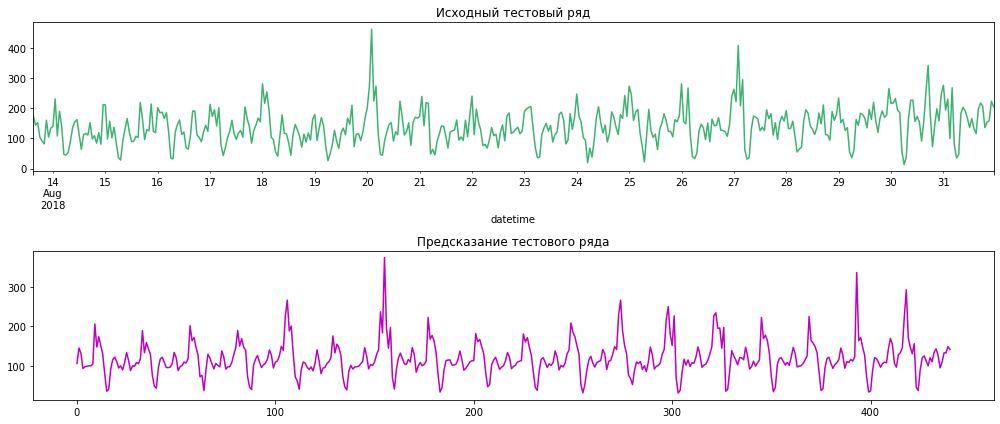

In [62]:
# оценим графики предсказания и реального целевого признака

plt.figure(figsize=(14,6))

plt.subplot(211)
yt_test.plot(ax=plt.gca(), color='mediumseagreen')
plt.title('Исходный тестовый ряд')

plt.subplot(212)
pd.Series(y_pred).plot(ax=plt.gca(), color='m')
plt.title('Предсказание тестового ряда')

plt.tight_layout()

# Вывод


<div class="alert alert-block alert-info">

 - Проведен обзор данных: данные приведены к формату временного ряда, проверена проверка пропусков в данных и проверка на хронологический порядок дат.
 - Для построения прогнозов на час выполнено ресемплирование по часу суммированием (были предоставлены данные за каждые 10 минут).
 - Проведена декомпозиция на сезонность и тренд - выявлен тренд на увеличение заказов (увеличение происходит с февраля по август, сделать более корректный вывод мешает маленький масштаб данных)
 
 
 - Поиск лучшей модели осуществлялся по двум направлениям - через создание оптимальных признаков (лаги и скользящее среднее с разным окном) и через подбор гиперпараметров модели сеткой GridSearch и TimeSeriesSplit.
 
 
 - По показателю RMSE рейтинг моделей слудующий: Градиентный бустинг(29.6), Случайный лес(33), Дерево решений(34.7), Линейная регрессия(36.1). Для прогнозов выбрана модель Градиентного бустинга.
 - Итоговый показатель RMSE тестовой выборки - 46